# Limpeza e transformação dos dados

Agora que temos coletamos todos os dados necessários para fazer nossas análises e modelos, vamo fazer uma tratativa em nossos DataFrames. Iremos interpretar cada coluna e unificar através de soma aquelas colunas que fazem parte de uma certa categoria, ficará mais fácil de entender daqui pra frente. Também iremos fazer novas requisições na API da Riot para transformar ID's de itens em seus respectivos nomes...

In [1]:
import pandas as pd
import requests

In [8]:
tops = pd.read_excel("original/TOP.xlsx")
jgs = pd.read_excel("original/JUNGLE.xlsx")
mids = pd.read_excel("original/MIDDLE.xlsx")
adcs = pd.read_excel("original/BOTTOM.xlsx")
sups = pd.read_excel("original/UTILITY.xlsx")

# Agrupando colunas.

### Agrupando colunas de pings:
- O tipo de ping não é um dado tão relevante assim, até porque o nível de agressividade ou passividade de um time ou jogador pode ser analisado através da quantidade de abates/ mortes e dano causado/sofrido.
Então iremos criar uma única coluna chamada **allPings** que será o agrupamento entre todas as colunas de Pings.

### Agrupando abates e assistências:
- Iremos unificar as colunas **assists** e **kills** e chamá-la de **participations**. Uma assistência é quando um jogador ajuda à matar um jogador inimigo, kills é auto-explicativo. Ambos tem o mesmo efeito prático na partida.

### Agrupando colunas de farm:
- Também iremos unificar as colunas **totalMinionsKilled, totalEnemyJungleMinionsKilled, totalAllyJungleMinionsKilled, neutralMinionsKilled** na coluna **totalFarm**. O farm é uma das formas de conquistar ouro dentro da partida, e você pode farmar minions e monstros da selva.


In [11]:
def remove_ping_columns(dataframe: pd.DataFrame):
  """Remove todas as colunas de tipos de ping e cria uma única coluna
    única com a soma de todos os pings da partida."""
  ping_columns = []
  for column in dataframe.columns:
    if 'Pings' in str(column):
      ping_columns.append(column)

  dataframe['allPings'] = dataframe[ping_columns].sum(axis=1)
  dataframe.drop(columns=ping_columns, inplace=True)

In [12]:
def sum_kills_and_assists(dataframe: pd.DataFrame):
  """Soma os abates e assistências do jogador em uma única coluna ``participations``"""
  dataframe['participations'] = dataframe['kills'] + dataframe['assists']

In [13]:
def sum_minions_and_jungle_minions_killed(dataframe: pd.DataFrame):
  """Soma todos os monstros pequenos em uma única coluna ``totalFarm``"""
  farm_columns = []
  for column in dataframe.columns:
    if 'MinionsKilled' in str(column):
      farm_columns.append(column)

  dataframe['totalFarm'] = dataframe[farm_columns].sum(axis=1)
  dataframe.drop(columns=farm_columns, inplace=True)

# Removendo colunas.

- O DataFrame possui uma coluna para ouro ganho e ouro gasto. Separar os dados dessa forma é irrelevante, iremos considerar apenas o ouro gasto na partida, pois o ouro ganho só tem efeito prático quando é gasto com itens. Iremos deletar a coluna **goldEarned**

- Iremos remover partidas que tenham acabado em rendição logo no início da partida. Esses dados são inúteis. A coluna que indica uma rendição rápida é **gameEndedInEarlySurrender**. Também iremos deletar **gameEndedInSurrender**.

- Nós já temos o nome do campeão que o jogador pickou e o seu level total, então iremos desconsiderar as colunas **championId** e **champExperience**.

- Também iremos deletar todas as colunas que indiquem abates múltiplos, como double-kills, triple-kills... Nós já teremos esses números na coluna **participations**. As colunas **doubleKills**, **tripleKills**, **quadraKills**, **pentaKills** **largestMultiKill**, **largestKillingSpree**, **killingSprees** serão deletadas.

- Não precisamos de informações pessoais dos jogadores. As colunas **summonerName, summonerLevel, summonerId, riotIdTagline riotIdGameName, puuid, profileIcon, participantId, eligibleForProgression** serão todas removidas

- Iremos considerar apenas o score de visão e remover as colunas **visionWardsBoughtInGame, wardsKilled, wardsPlaced, sightWardsBoughtInGame, detectorWardsPlaced**

- Vamos remover a coluna **itemsPurchased** e utilizar apenas **consumablesPurchased** para ver se a compra excessiva de poções influencia no desempenho de um jogador(tenho a intuição de que sim)

- Iremos remover as colunas **damageDealtToBuildings** e **damageDealtToTurrets**, a coluna **damageDealtToObjectives** é a soma dessas outras duas, é o suficiente pra nossa análise.

- As colunas **nexusKills**, **nexusLost** e **nexusTakedowns** tem uma correlação perfeita com a vitória(basicamente se você destrói o nexus você ganha a partida). Iremos deletá-las.

- Iremos deletar a coluna **firstBloodKill** e considerar apenas **firstBloodAssist**, é o suficiente pra saber se um time começou com a primeira kill do jogo ou não.

- Iremos remover colunas isoladas com significado irrelevante ou duplicado, como **championTransform, largestCriticalStrike, lane, role, inhibitorKills, physicalDamageDealt, physicalDamageTaken, firstTowerKill,
magicDamageDealt, magicDamageTaken, teamEarlySurrendered, totalDamageDealt, trueDamageDealt,
trueDamageTaken, firstTowerKill, objectivesStolen, turretKills, teamPosition, totalDamageShieldedOnTeammates, totalTimeCCDealt, totalUnitsHealed**

- Por último, iremos remover colunas que possuem sempre um valor único

In [14]:
def remove_columns_with_unique_values(dataframe: pd.DataFrame):
  """Remove todas as colunas do dataframe que possuem valores unique"""
  for colum in dataframe.columns:
      if dataframe[colum].nunique() == 1:
          dataframe.drop(colum, axis=1, inplace=True)

In [15]:
def remove_games_that_ended_in_early_surrender(dataframe: pd.DataFrame):
  """Remove todas as partidas que terminaram em remake"""
  dataframe.drop(dataframe[dataframe["gameEndedInEarlySurrender"]].index, inplace=True)

In [16]:
def delete_generic_columns(dataframe: pd.DataFrame):
  """Deleta todas as colunas genéricas e irrelevantes do dataframe"""
  columns_to_delete = [
    "goldEarned", "championId", "champExperience", "doubleKills", "tripleKills", "quadraKills",
    "pentaKills", "largestMultiKill", "largestKillingSpree", "killingSprees", "summonerName",
    "summonerLevel", "summonerId", "riotIdTagline", "riotIdGameName", "puuid", "profileIcon",
    "participantId", "eligibleForProgression", "visionWardsBoughtInGame", "wardsKilled",
    "wardsPlaced", "gameEndedInEarlySurrender", "assists", "kills", "gameEndedInSurrender",
    "detectorWardsPlaced", "championTransform", "itemsPurchased", "inhibitorKills",
    "damageDealtToBuildings", "damageDealtToTurrets", "largestCriticalStrike", "lane",
    "role", "nexusLost", "nexusKills", "nexusTakedowns", "firstBloodKill",
    "physicalDamageDealt", "physicalDamageTaken", "firstTowerKill", "magicDamageDealt",
    "magicDamageTaken", "teamEarlySurrendered", "totalDamageDealt", "trueDamageDealt",
    "trueDamageTaken", "objectivesStolen", "turretKills",
    "totalDamageShieldedOnTeammates", "totalTimeCCDealt", "totalUnitsHealed"
  ]
  dataframe.drop(columns=columns_to_delete, inplace=True)

# Transformando colunas

- A riot nos disponibiliza o ID dos itens e não o seu nome. Iremos fazer uma requisição para o datadragon da Riot e puxar o nome dos itens pelo seu ID

- Eu não encontrei uma rota que disponibilizasse o ID dos feitiços de invocador, mas como são poucos, eu defini um dicionário com cada spell.

In [17]:
def get_item_name_by_id(dataframe: pd.DataFrame):
  itens = "https://ddragon.leagueoflegends.com/cdn/14.11.1/data/pt_BR/item.json"
  response = requests.get(itens).json()['data']

  for item in ["item0", "item1", "item2", "item3", "item4", "item5", "item6"]:
    dataframe[item] = dataframe[item].apply(lambda s: response.get(str(s), {}).get('name', "No Item"))

In [18]:
def get_spell_name_by_id(dataframe: pd.DataFrame):
  spells = {"4": 'Flash', "12": 'Teleport', "14": 'Ignite', "11": 'Smite', "7": 'Heal', "6": 'Haste', "3": 'Exhaust', "1": 'Cleanse', "21": 'Barrier'}
  for spell in ["summoner1Id", "summoner2Id"]:
    dataframe[spell] = dataframe[spell].apply(lambda x: spells.get(str(x)), None)

# Finalizando a limpeza de dados.

Com todas as limpezas que fizemos, conseguimos reduzir a quantidade de colunas do nosso DataFrame de 127 para 50... Agora nós temos uma base de dados com a seguinte estrutura:

| Nome da Variável | Tipo | Descrição
|------------------|------|----------|
| baronKills       | int  | Quantidade de barões de nashor feitos |
| bountyLevel      | int  | O nível de recompensa do jogador(quantidade de ouro que ele está valendo) |
| champLevel       | int  | O nível do campeão |
| championName     | str  | O nome do campeão  |
| consumablesPurchased | int | A quantidade de itens consumíveis comprados |
| damageDealtToObjectives | int | O total de dano dado em objetivos |
| damageSelfMitigated | int | O total de dano auto-mitigado de inimigos |
| dragonKills | int | Quantidade de dragões feitos |
| firstBloodAssist | bool | Se o jogador teve participação na primeira kill do jogo |
| firstTowerAssist | bool | Se o jogador teve participação na primeira torre derrubada no jogo |
| goldSpent | int | Total de ouro gasto durante a partida
| individualPosition | str | A posição na qual o jogador jogou |
| inhibitorTakedowns | int | Quantidade de inibidores derrubados |
| inhibitorsLost | int | Quantidade de inibidores perdidos |
| item0 | str | Nome do Item 0 |
| item1 | str | Nome do Item 1 |
| item2 | str | Nome do Item 2 |
| item3 | str | Nome do Item 3 |
| item4 | str | Nome do Item 4 |
| item5 | str | Nome do Item 5 |
| item6 | str | Nome do Item 6 |
| longestTimeSpentLiving | int | Maior quantidade de tempo sem morrer |
| magicDamageDealtToChampions | int | Total de dano mágico causado |
| objectivesStolenAssists | int | Quantidade de participações em objetivos roubados |
| physicalDamageDealtToChampions | int | Dano físico causado em outros jogadores |
| spell1Casts | int | Quantidade que a skill "Q" foi utilizada |
| spell2Casts | int | Quantidade que a skill "W" foi utilizada |
| spell3Casts | int | Quantidade que a skill "E" foi utilizada |
| spell4Casts | int | Quantidade que a skill "R" foi utilizada |
| summoner1Casts | int | Quantidade que a skill "D" foi utilizada |
| summoner2Casts | int | Quantidade que a skill "F" foi utilizada |
| summoner1Id | str | Feitiço de invocador 1 |
| summoner2Id | str | Feitiço de invocador 2 |
| teamId | int | O lado do mapa que o jogador jogou |
| timeCCingOthers | int | Tempo de atordoamento causado à jogadores inimigos |
| timePlayed | int | Tempo de partida |
| totalDamageDealtToChampions | int | Dano total causado |
| totalDamageTaken |int | Dano total sofrido |
| totalHeal | int | Cura total recebida |
| totalHealsOnTeammates | int | Cura total dada ao time aliado |
| totalTimeSpentDead | int | Tempo passado morto |
| trueDamageDealtToChampions | int | Total de dano verdadeiro causado |
| turretTakedowns | int | Quantidade de torres derrubadas |
| turretsLost | int | Quantidade de torres perdidas |
| visionScore | int | Score de visão |
| win | bool | Se a partida foi vencida ou não |
| allPings | int | Quantidade de pings feitos |
| participations | int | Quantidade de participações em abates |
| totalFarm | int | Quantidade de farm |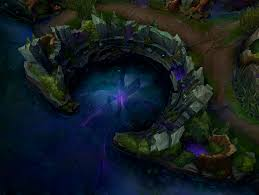

Executando as funções e salvando os DataFrames

In [19]:
for role, dataframe in {'TOP': tops, 'MIDDLE': mids, 'JUNGLE': jgs, 'BOTTOM': adcs, 'UTILITY': sups}.items():
  remove_games_that_ended_in_early_surrender(dataframe)
  remove_ping_columns(dataframe)
  sum_kills_and_assists(dataframe)
  sum_minions_and_jungle_minions_killed(dataframe)
  delete_generic_columns(dataframe)
  remove_columns_with_unique_values(dataframe)
  get_item_name_by_id(dataframe)
  get_spell_name_by_id(dataframe)

  dataframe.to_excel(f'transformed/{role}.xlsx')

C:\Users\shady\AppData\Local\Temp\ipykernel_11568\1805924307.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dataframe[spell] = dataframe[spell].apply(lambda x: spells.get(str(x)), None)
C:\Users\shady\AppData\Local\Temp\ipykernel_11568\1805924307.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dataframe[spell] = dataframe[spell].apply(lambda x: spells.get(str(x)), None)
C:\Users\shady\AppData\Local\Temp\ipykernel_11568\1805924307.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dataframe[spell] = dataframe[spell].apply(lambda x: spells.get(str(x)), None)
C:\Users\shady\AppData\Lo

In [20]:
top_jgs = pd.concat([tops, jgs])
mids_adcs = pd.concat([mids, adcs])
matchs = pd.concat([top_jgs, mids_adcs])
matchs = pd.concat([matchs, sups])

matchs.to_excel("transformed/MATCHS.xlsx")